In [1]:
import os
from glob import glob
import random
from pathlib import Path
import pickle
from functools import partial
import numpy as np
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();
from IPython.display import clear_output
from celluloid import Camera

from skimage.filters import gaussian

from sage.training.trainer import MRITrainer
from sage.visualization.vistool import plot_vismap
from sage.visualization.utils import check_type
from sage.config import load_config
from utils.analysis import (
    Result, FileSelector, 
    group_stats, cherry_picker, check_existence, save2nifti, MAE
)

In [2]:
AVG = np.load("./data/average.npy")
naive_sel = FileSelector("naive")
gt_result = np.array(naive_sel.test_gt)
epoch_parser = lambda path: int(path.split("/layer0/ep")[-1].split("_mae")[0])
mae_parser = lambda path: float(path.split("_mae")[-1].split(".npy")[0])

In [3]:
with open("./data/naive_reg_test_100.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_reg_test_100.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [4]:
with open("./data/naive_nonreg_test_100.pkl", "rb") as f:
    naive_nonreg_results = pickle.load(f)
    naive_nonreg_results = {e[0]: e[1] for e in sorted(naive_nonreg_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_nonreg_test_100.pkl", "rb") as f:
    augment_nonreg_results = pickle.load(f)
    augment_nonreg_results = {e[0]: e[1] for e in sorted(augment_nonreg_results.items(), key=lambda x: x[0])}

In [5]:
naive = Result(naive_results)
augment = Result(augment_results)

naive_nonreg = Result(naive_nonreg_results)
augment_nonreg = Result(augment_nonreg_results)

### Dataset Histogram

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

labels = pd.read_csv("../brainmask_mni/label.csv")

train, test = train_test_split(labels, test_size=.1, random_state=42)
labels.loc[train.index.tolist(), "train/test"] = "train"
labels.loc[test.index.tolist(), "train/test"] = "test"

In [27]:
get_db = lambda db: labels[labels["src"] == db]

len(get_db("Oasis1"))

315

/opt/conda/envs/research/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/research/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


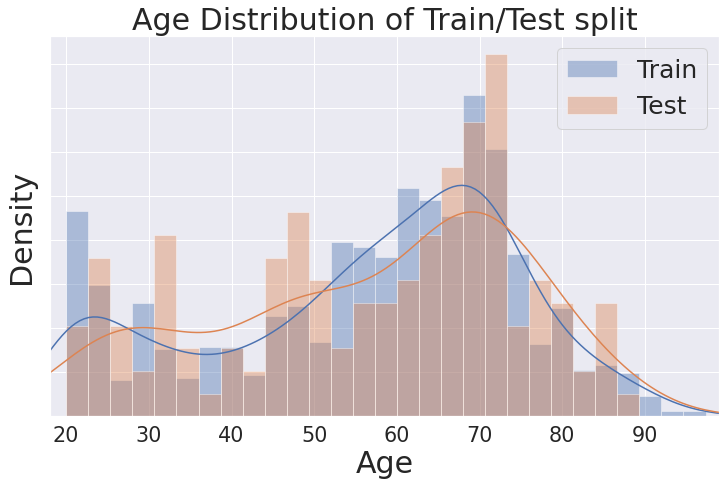

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.set_title("Age Distribution of Train/Test split", size=30)

sns.distplot(train.age, ax=ax, hist_kws={"range": (20, 100)}, label="Train", bins=30)
sns.distplot(test.age, ax=ax, hist_kws={"range": (20, 100)}, label="Test", bins=30)

ax.set_xlabel("Age", size=30)
ax.set_ylabel("Density", size=30)
ax.tick_params(axis="x", labelsize="xx-large")
ax.set_xlim(18, 99)
ax.legend(prop={"size": 25})
ax.set_yticklabels([]);

Text(0.5, 1.0, 'Dataset Age Distribution')

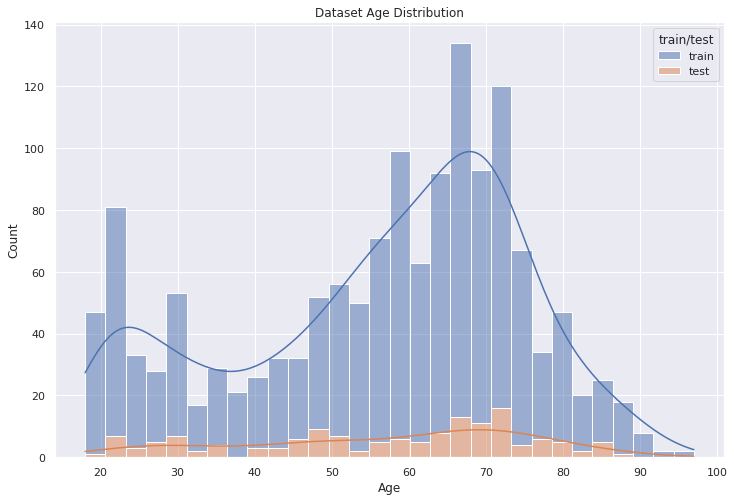

In [34]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.histplot(data=labels, x="age", hue="train/test", multiple="stack", ax=ax, bins=30, kde=True, stat="count")
ax.set_xlabel("Age", size="x-large")
# ax.set_ylabel("Count")
ax.set_title("Dataset Age Distribution")

## Value Range Plot

x: Epoch   
y: MAE   
error bar: histo value range   

In [58]:
ROOT = {
    "naive": "../resnet256_naive_checkpoints/",
    "augment": "../resnet256_augmentation_checkpoints/",
    "naive_nonreg": "../resnet256_naive_nonreg_checkpoints/",
    "augment_nonreg": "../resnet256_augmentation_nonreg_checkpoints/",
}
def get_npy_list(config, run_date):

    root = ROOT[config]
    npy_list = glob(root + run_date + "/npy_std/layer0/*.npy")
    return sorted(npy_list)

def get_epoch_from_path(npy_path):

    return int(npy_path.split("ep")[1].split("_")[0])

def get_mae_from_path(npy_path):

    return float(npy_path.split("_mae")[1].split(".npy")[0])

def get_6sigma(ndarray):

    if isinstance(ndarray, str):
        ndarray = np.load(ndarray)

    mean = np.mean(ndarray)
    std = np.std(ndarray)
    
    return mean + 3 * std

In [59]:
config = "naive"
run_index = 0

def get_errorbar_data(npy_list):

    return [
        (
            get_epoch_from_path(npy_path),
            get_mae_from_path(npy_path),
            get_6sigma(npy_path),
        ) for npy_path in npy_list
    ]

<ErrorbarContainer object of 3 artists>

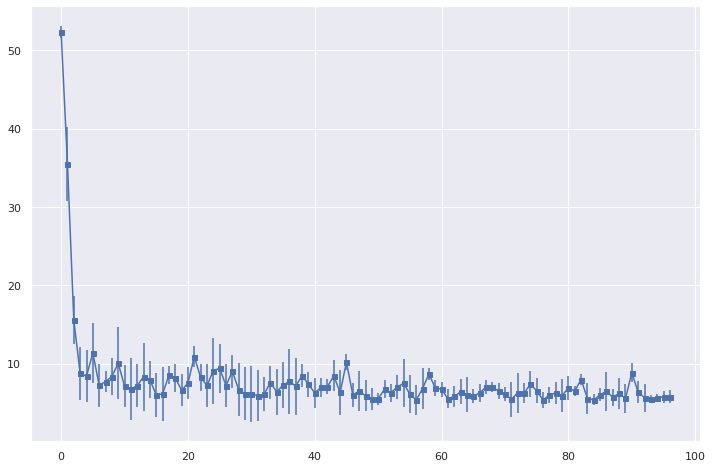

In [66]:
val = get_errorbar_data(npy_list)

plt.figure(figsize=(12, 8))
plt.errorbar(
    [_[0] for _ in val], [_[1] for _ in val], yerr=[_[2] * 5 for _ in val], ms=5, marker="s",
)

In [68]:
naive_npy_vals = {}
augment_npy_vals = {}
for idx in range(100):

    naive_npy_list = get_npy_list("naive", naive.get_runname(idx))
    naive_error = [_[2] for _ in get_errorbar_data(naive_npy_list)]
    naive_npy_vals[idx] = naive_error

    
    augment_npy_list = get_npy_list("augment", augment.get_runname(idx))
    augment_error = [_[2] for _ in get_errorbar_data(augment_npy_list)]
    augment_npy_vals[idx] = augment_error

In [78]:
import random

indices = random.sample(range(100), 10)


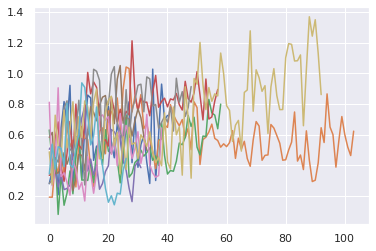

In [79]:
for idx in indices:
    plt.plot(naive_npy_vals[idx])
plt.show()

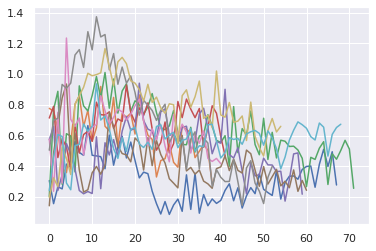

In [80]:
for idx in indices:
    plt.plot(augment_npy_vals[idx])
plt.show()

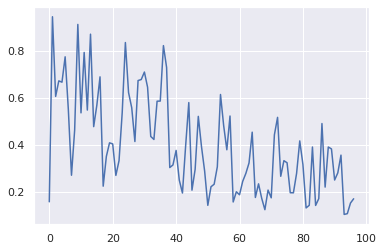

In [67]:
for idx in range(100):

    plt.plot

In [43]:
npy_list = get_npy_list("naive", naive.get_runname(0))
sample_array = get_6sigma(npy_list[2])

(-0.6061703037056656, 0.6061702896323471)